In [78]:
import pandas as pd
import numpy as np

In [79]:
import re

In [80]:
import requests

In [81]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity

In [124]:
df = pd.read_csv('fake.csv')
df = df[df.language=='english']
df.loc[df['text'].isnull(), 'text'] = ''
df.loc[df['thread_title'].isnull(),'thread_title'] = ''

In [125]:
ranks = [i for i in df['domain_rank'].tolist() if np.isnan(i) == False]

In [126]:
participants_frequency = pd.crosstab(index = df['participants_count'], columns='count')

In [127]:
set([i for i in df['type'].tolist()])

{'bias', 'bs', 'conspiracy', 'fake', 'hate', 'junksci', 'satire', 'state'}

In [128]:
df.describe()

,ord_in_thread,domain_rank,spam_score,replies_count,participants_count,likes,comments,shares
count,12403.000000,8228.000000,12403.000000,12403.000000,12403.000000,12403.000000,12403.000000,12403.000000
mean,0.934371,38715.689961,0.024484,1.449649,1.779973,10.416593,0.028300,10.416593
std,6.637846,26978.438752,0.120583,9.881279,7.042666,78.689100,0.543768,78.689100
min,0.000000,486.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,17592.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,34478.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,61423.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,100.000000,98679.000000,1.000000,309.000000,240.000000,988.000000,30.000000,988.000000


## Part One

In [129]:
for column in list(df.columns):
    if df[column].count()<len(df):
        print(column, df[column].count())

author 10194
title 11723
country 12227
domain_rank 8228
main_img_url 8779


In [130]:
r = requests.get('https://raw.githubusercontent.com/stanfordnlp/CoreNLP/master/data/edu/stanford/nlp/patterns/surface/stopwords.txt')
stopwords = set(r.text.split())
more_words = ["t","m", "ll","re","don","doesn"]
stopwords |= set(more_words)

In [131]:
df['text_lower'] = df['text'].map(lambda x: re.sub(r'[^a-z ]','',x.lower()))
df['text_lower'] = df['text_lower'].map(lambda x: ' '.join([word for word in x.strip().split() if word not in stopwords]))

In [133]:
df['thread_lower'] = df['thread_title'].map(lambda x: re.sub(r'[^a-z ]','',x.lower()))
df['thread_lower'] = df['thread_lower'].map(lambda x: ' '.join([word for word in x.strip().split() if word not in stopwords]))

In [134]:
def reverse(string):
    return string.split('.')[1] + '.' + string.split('.')[0]
df['site_url'] = df['site_url'].map(lambda x: reverse(x))

In [82]:
### Similarities of two texts
def similarity(t1,t2):
    t = [t1,t2]
    tfidf_vectorizer = TfidfVectorizer()
    vectors = tfidf_vectorizer.fit_transform(t)
    vectors = vectors.toarray()
    sim = cosine_similarity(vectors[0].reshape(1,-1),vectors[1].reshape(1,-1))[0]
    
    return sim

In [86]:
similarity('You will have to arrange to print late poster submissions on your own', 'I highly encourage you to meet with me and discuss your ideas before submitting your draft')

array([ 0.19472336])

## Part Two: GBC with second dataset

In [486]:
df2 = shuffle(pd.read_csv('fake_or_real_news.csv'))
df2_train, df2_test = train_test_split(df2, test_size=0.2, random_state=1)

In [31]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

In [32]:
title_count = count_vect.fit_transform(df2['title'])
title_tfidf = tfidf_transformer.fit_transform(title_count)
(title_tfidf_train, title_tfidf_test, Y_train, Y_test) = train_test_split(title_tfidf, 
                                                                  df2['label'], 
                                                                  test_size=0.2, random_state=1)

In [34]:
gbc = GradientBoostingClassifier().fit(title_tfidf_train, Y_train)
title_pred = gbc.predict(title_tfidf_test)
confusion_matrix(Y_test, title_pred)

array([[553,  73],
       [239, 402]], dtype=int64)

## Part Three: PageRank file.

In [ ]:
fake_news = list(set(df['site_url']))

In [144]:
def find_authority():
    """Look up harmonic centrality and page rank positions for fake news websites. Store values in list"""
    ranks = {}
    with open('ranks.txt','r') as f:
        next(f)
        for line in f:
            lst = line.split()
            site = lst[4]
            if site in url_list:
                site = reverse(site)
                ranks[site] = [lst[2], lst[0]]
    return ranks
print(find_authority())

{'naturalnews.com': ['944', '269'], 'rt.com': ['3231', '902'], 'infowars.com': ['10621', '1317'], 'zerohedge.com': ['7159', '1637'], 'theonion.com': ['3648', '2081'], 'beforeitsnews.com': ['13333', '2128'], 'breitbart.com': ['4168', '2571'], 'wnd.com': ['8241', '2593'], 'globalresearch.ca': ['10723', '2595'], 'wikileaks.org': ['6380', '2770'], 'counterpunch.org': ['11956', '3065'], 'truth-out.org': ['10481', '3133'], 'abcnews.com': ['13466', '3357'], 'guardianlv.com': ['8382', '3380'], 'presstv.ir': ['16238', '3497'], 'rense.com': ['18816', '3921'], 'lewrockwell.com': ['20457', '3992'], 'drudgereport.com': ['4550', '4424'], 'frontpagemag.com': ['23423', '4484'], 'sott.net': ['27166', '4729'], 'collective-evolution.com': ['28439', '5041'], 'thenewamerican.com': ['27248', '5194'], 'sputniknews.com': ['8087', '5583'], 'coasttocoastam.com': ['32323', '5844'], 'mintpressnews.com': ['35385', '6003'], 'activistpost.com': ['25411', '6020'], 'rbth.com': ['19329', '6065'], 'opednews.com': ['3204

PageRank counts the number of possible ways to reach the given site from any other sites. Harmonic Centrality calculates the total degree of inlinks. We note that most fake news websites have lower HC positions than PR positions. This is probably because fake news websites tend to trap users from going back to credible sites, while they may be reached from other more credible sites. 

In [347]:
def search_site(site):
    """Looks for a site in page rank file. Input can include .com or not"""
    with open('ranks.txt','r') as f:
        next(f)
        for line in f:
            lst = line.split()
            if ('.' in site and '.'.join(site.split('.')[::-1])== lst[4]) or site in lst[4].split('.'):
                return lst
        return False

In [351]:
def find_ranks(lst):
    """Generalized version of find_authority. Takes a little while to run for long lists."""
    ranks = {}
    for i in lst:
        if search_site(i) is not False:
            ranks[i] = [search_site(i)[0], search_site(i)[2]]
        else: continue
    return ranks

In [300]:
fake_ranks = {'naturalnews.com': ['944', '269'], 'rt.com': ['3231', '902'], 'infowars.com': ['10621', '1317'], 'zerohedge.com': ['7159', '1637'], 'theonion.com': ['3648', '2081'], 'beforeitsnews.com': ['13333', '2128'], 'breitbart.com': ['4168', '2571'], 'wnd.com': ['8241', '2593'], 'globalresearch.ca': ['10723', '2595'], 'wikileaks.org': ['6380', '2770'], 'counterpunch.org': ['11956', '3065'], 'truth-out.org': ['10481', '3133'], 'abcnews.com': ['13466', '3357'], 'guardianlv.com': ['8382', '3380'], 'presstv.ir': ['16238', '3497'], 'rense.com': ['18816', '3921'], 'lewrockwell.com': ['20457', '3992'], 'drudgereport.com': ['4550', '4424'], 'frontpagemag.com': ['23423', '4484'], 'sott.net': ['27166', '4729'], 'collective-evolution.com': ['28439', '5041'], 'thenewamerican.com': ['27248', '5194'], 'sputniknews.com': ['8087', '5583'], 'coasttocoastam.com': ['32323', '5844'], 'mintpressnews.com': ['35385', '6003'], 'activistpost.com': ['25411', '6020'], 'rbth.com': ['19329', '6065'], 'opednews.com': ['32040', '6195'], 'rinf.com': ['109423', '6362'], 'yournewswire.com': ['62231', '6410'], 'prisonplanet.com': ['30258', '6468'], 'abovetopsecret.com': ['39676', '7246'], 'whatreallyhappened.com': ['54006', '7476'], 'endtime.com': ['259674', '7570'], 'thefreethoughtproject.com': ['44209', '7751'], 'veteranstoday.com': ['38714', '7815'], 'informationclearinghouse.info': ['43660', '7963'], 'washingtonsblog.com': ['58350', '8220'], 'theantimedia.org': ['81505', '8528'], 'westernjournalism.com': ['34302', '8606'], '21stcenturywire.com': ['91514', '8676'], 'antiwar.com': ['36800', '8715'], 'investmentwatchblog.com': ['92326', '8827'], 'presstv.com': ['40103', '8857'], 'dailywire.com': ['41067', '9073'], 'nutritionfacts.org': ['10086', '9376'], 'intellihub.com': ['129202', '9456'], 'nakedcapitalism.com': ['42223', '9562'], 'thedailysheeple.com': ['120530', '9815'], 'disclose.tv': ['60236', '10110'], 'paulcraigroberts.org': ['93407', '10304'], 'thedailywtf.com': ['26656', '10440'], 'blacklistednews.com': ['142072', '10491'], 'newstarget.com': ['107208', '10585'], 'theeconomiccollapseblog.com': ['74221', '10742'], 'voltairenet.org': ['50063', '10875'], 'nowtheendbegins.com': ['103495', '11013'], 'anonhq.com': ['138269', '11160'], 'godlikeproductions.com': ['99317', '11292'], 'vigilantcitizen.com': ['104645', '11536'], 'kingworldnews.com': ['124257', '11588'], 'usuncut.com': ['109483', '11681'], 'southfront.org': ['187058', '12029'], 'dailystormer.com': ['133746', '12070'], 'endoftheamericandream.com': ['136509', '12221'], 'strategic-culture.org': ['121799', '12355'], 'ronpaulinstitute.org': ['124886', '12406'], 'conservativetribune.com': ['53060', '12422'], 'barenakedislam.com': ['117177', '12520'], 'vdare.com': ['78827', '12533'], 'eutimes.net': ['189000', '12617'], 'davidduke.com': ['149996', '12937'], 'in5d.com': ['168786', '13006'], 'rumormillnews.com': ['165288', '13037'], 'geoengineeringwatch.org': ['121659', '13616'], 'unz.com': ['137313', '13730'], 'shtfplan.com': ['87126', '13913'], 'russia-insider.com': ['133073', '13930'], 'blackagendareport.com': ['123029', '13993'], 'wearechange.org': ['58657', '14356'], 'amren.com': ['43371', '14432'], 'foreignpolicyjournal.com': ['110080', '14979'], 'humansarefree.com': ['127187', '15180'], 'worldtruth.tv': ['191999', '15507'], 'thecommonsenseshow.com': ['206829', '15845'], 'katehon.com': ['261967', '16137'], 'corbettreport.com': ['110617', '16331'], 'trunews.com': ['166222', '16853'], 'other98.com': ['275787', '16855'], 'fort-russ.com': ['408328', '16904'], 'pakalertpress.com': ['234502', '17089'], 'hangthebankers.com': ['218025', '17520'], 'moonofalabama.org': ['221893', '17596'], 'silverdoctors.com': ['158983', '17690'], 'davidwolfe.com': ['96507', '17997'], 'thesaker.is': ['239935', '21398'], 'sgtreport.com': ['261128', '21681'], 'galacticconnection.com': ['329773', '23791'], 'therebel.media': ['60530', '24098'], 'readynutrition.com': ['263135', '24669'], 'projectveritas.com': ['200912', '26024'], 'intrepidreport.com': ['505991', '27599'], 'topinfopost.com': ['271820', '28151'], 'addictinginfo.org': ['67909', '32629'], 'amtvmedia.com': ['342533', '33536'], 'libertywritersnews.com': ['563779', '33745'], 'twitchy.com': ['27369', '40008'], 'truthdig.com': ['23935', '40203'], 'thefederalistpapers.org': ['190490', '43697'], 'filmsforaction.org': ['20477', '44156'], 'thesleuthjournal.com': ['220068', '45079'], 'fromthetrenchesworldreport.com': ['27877', '45409'], 'consortiumnews.com': ['54284', '45884'], 'politicususa.com': ['42042', '46167'], 'countercurrents.org': ['60350', '48263'], 'consciouslifenews.com': ['124195', '50204'], 'wakingtimes.com': ['82687', '50426'], 'clickhole.com': ['71781', '52774'], 'freedomoutpost.com': ['159034', '53810'], 'henrymakow.com': ['101646', '54135'], 'theduran.com': ['253023', '55367'], 'ijr.com': ['29450', '56675'], 'healthimpactnews.com': ['62641', '60390'], 'trueactivist.com': ['91619', '60633'], 'realfarmacy.com': ['109883', '64808'], 'liberalamerica.org': ['332504', '65222'], 'pravdareport.com': ['179625', '67196'], 'gomerblog.com': ['767882', '67757'], 'madworldnews.com': ['244765', '68421'], 'theeventchronicle.com': ['314576', '70072'], 'newsbiscuit.com': ['201986', '70293'], 'shadowproof.com': ['146037', '71153'], 'journal-neo.org': ['201797', '72189'], 'thespoof.com': ['234753', '72199'], 'whydontyoutrythis.com': ['190663', '72570'], 'returnofkings.com': ['116952', '75450'], 'libertyunyielding.com': ['335103', '75690'], 'redflagnews.com': ['299994', '76939'], 'thepeoplescube.com': ['236181', '78746'], 'thedailybell.com': ['130935', '81561'], 'legorafi.fr': ['151819', '82861'], 'occupydemocrats.com': ['233852', '84197'], 'bipartisanreport.com': ['433528', '85117'], 'satirewire.com': ['247984', '86417'], 'fellowshipoftheminds.com': ['392036', '87962'], 'educateinspirechange.org': ['218380', '88519'], 'dcclothesline.com': ['316684', '89504'], 'libertyblitzkrieg.com': ['351681', '89791'], 'secretsofthefed.com': ['291019', '92337'], 'naturalblaze.com': ['378339', '99797'], 'russia-direct.org': ['348010', '101188'], 'chronicle.su': ['683521', '101970'], 'greanvillepost.com': ['546397', '103849'], 'orientalreview.org': ['398433', '104055'], 'undergroundhealth.com': ['425595', '110704'], 'therundownlive.com': ['330770', '111551'], 'conservativedailypost.com': ['599033', '114393'], 'redstatewatcher.com': ['716808', '114485'], 'veteransnewsnow.com': ['423673', '115669'], 'endingthefed.com': ['1015182', '124183'], 'darkmoon.me': ['686092', '129566'], 'ahtribune.com': ['255299', '132458'], 'truthfrequencyradio.com': ['270497', '134769'], 'newsthump.com': ['142976', '144682'], 'anonews.co': ['252022', '146704'], 'off-guardian.org': ['709749', '149848'], 'libertynews.com': ['403635', '154456'], 'survivopedia.com': ['666043', '157515'], 'truthfeed.com': ['519870', '164491'], 'ifyouonlynews.com': ['797543', '172092'], 'dailynewsbin.com': ['943013', '181467'], 'allnewspipeline.com': ['438255', '182570'], 'reductress.com': ['178016', '184151'], 'betootaadvocate.com': ['1057220', '184572'], 'abeldanger.net': ['1499523', '185168'], 'themindunleashed.com': ['74948', '190729'], 'americanlookout.com': ['250973', '214257'], 'toprightnews.com': ['771020', '253636'], 'ewao.com': ['504133', '254550'], '100percentfedup.com': ['414725', '264689'], 'dennismichaellynch.com': ['664442', '315430'], 'truthandaction.org': ['672641', '331570'], 'govtslaves.info': ['694711', '332638'], 'theunrealtimes.com': ['189704', '333037'], 'ncscooper.com': ['968012', '333646'], 'waterfordwhispersnews.com': ['476632', '335576'], 'ufoholic.com': ['1868239', '336841'], 'americannews.com': ['1031186', '340665'], 'truthkings.com': ['1480266', '347924'], 'christiantimesnewspaper.com': ['1167311', '362682'], 'patriotrising.com': ['1173780', '362771'], 'usapoliticsnow.com': ['2862567', '364697'], 'defenddemocracy.press': ['1835256', '366194'], 'prepperwebsite.com': ['721875', '369856'], 'worldnewspolitics.com': ['1716085', '374228'], 'empireherald.com': ['2801629', '382395'], 'winningdemocrats.com': ['1588371', '388641'], 'thecontroversialfiles.net': ['2920448', '389616'], 'usanewsflash.com': ['1507899', '405550'], 'proudemocrat.com': ['4120384', '424213'], 'davidstockmanscontracorner.com': ['215832', '1095740'], 'awdnews.com': ['427772', '1104682'], 'shiftfrequency.com': ['352851', '1107003'], 'gulagbound.com': ['300377', '1111031'], 'morningnewsusa.com': ['330008', '1111881'], 'regated.com': ['3276917', '1258603'], 'adobochronicles.com': ['1891592', '1488171'], 'thelastlineofdefense.org': ['826573', '1498367'], 'investmentresearchdynamics.com': ['785301', '2050556'], 'magafeed.com': ['3200620', '2084077'], 'americasfreedomfighters.com': ['929387', '2183892'], 'therussophile.org': ['2166710', '2254642'], 'ihavethetruth.com': ['388356', '2900756'], 'the-newspapers.com': ['6776828', '2939728'], 'usasupreme.com': ['2201663', '2940547'], 'wundergroundmusic.com': ['1805363', '2954938'], 'truthbroadcastnetwork.com': ['8399693', '2961936'], 'viralliberty.com': ['2660439', '2978710'], 'eyeopening.info': ['1536492', '2996900'], 'newcenturytimes.com': ['4140634', '3064353'], 'donaldtrumpnews.co': ['3528408', '3187988'], 'usatwentyfour.com': ['2752487', '3205832'], 'bignuggetnews.com': ['15826369', '3450512'], 'departed.co': ['6882162', '3498088'], 'spinzon.com': ['13114074', '3533957'], 'topratedviral.com': ['8157719', '3606765'], 'miniplanet.us': ['14204876', '3749330'], 'indiaarising.com': ['20857653', '4894447'], 'usanewsinsider.com': ['16937704', '5611977'], 'bigbluevision.org': ['33891985', '6073145'], 'presidentialvoting2016.com': ['36674747', '6203404'], 'jewsnews.co': ['52184255', '18628363']}

In [329]:
real_news = open('real_sites.txt', 'r').read().split('\n')

In [372]:
real_news=['abcnews','abc','aftenposten','aljazeera','ansa','argaam','arstechnica','arynews','ap','afr','axios','bbc','bild','blastingnews','bleacherreport','businessinsider','businessinsider',
 'cnn','cnnespanol','cryptocoin','dailymail','tagesspiegel','zeit','elmundo','engadget','ew','espn','espncricinfo','financialpost','ft','focus','football-italia','fortune','fourfourtwo','foxnews','foxsports','globo','israelnationalnews','gp.se','gruenderszene','ycombinator','handelsblatt','ign','ilsole24ore','independent','infobae','xinhua-net','vice','time','washingtontimes','wsj','indiatimes','theverge','washingtonpost','telegraph','nytimes','thenextweb','thesportbible','thehindu','huffingtonpost','irishtimes','ladbiblegroup','thehill','theguardian','theglobeandmail','techcrunch','techradar','futurecdn','economist','svd','talksport','t3n','rte','rtlnieuws','sabq','spiegel','wiwo','recode','nrk','polygon','rbc','reuters','nfl','nhl','nba','mls','mlb','nextbigfuture','nymag','sina','163','news24','news','newsweek','mtv','nationalgeographic','nationalreview','nbcnews','mtv','msnbc','mirror','metro','liberation','marca','mashable','medicalnewstoday','usatoday','ynet','wired','lemonde','lesechos','lequipe','lenta','repubblica','lanacion','lageceta','infomoney','japantimes','japantoday','koreatimes','koreaherald','kcnawatch','vietnamnews.vn','tuoitrenews','france24','connexionfrance','moroccoworldnews','chinadaily','globaltimes.cn','cctv.com','scmp','cctv.cn','hindustantimes','samachar','capitalmarket','thebigproject','zeenews','thesouthafrican','sowetanlive','allafrica','ft','dailytelegraph','thelocal.it','thelocal.fr','thelocal.dk','thelocal.se','thelocal.ch','cphpost','euronews','dailynewshungary','kormany.hu','budapestbeacon','radio.cz','praguemonitor','startribune','twincities','jsonline','nbclosangeles','sacbee','mercurynews','nzherald','tvnz','autosport','mexiconewsdaily','kcci','desmoinesregister','masslive','wcvb']

## Part Four: Domain Classifier

In [469]:
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [610]:
len(list(fake_ranks.values())[:163])

163

In [611]:
real_values = list(real_ranks.values())
fake_values = list(fake_ranks.values())[:163]
features = real_values + fake_values
labels = [1 for i in range(163)]+[0 for i in range(163)]

In [612]:
len(labels)

326

In [613]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [614]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [615]:
Y_pred = clf.predict(X_test)
confusion_matrix(y_test, Y_pred)

array([[28,  7],
       [ 5, 26]], dtype=int64)

In [616]:
Y_pred

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0])

In [617]:
pd.crosstab(pd.Series(y_test), pd.Series(Y_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,28,7,35
1,5,26,31
All,33,33,66


In [618]:
import pickle
filename = 'domain_clf.sav'
pickle.dump(clf, open(filename, 'wb'))

In [619]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_train, y_train) 

In [620]:
Y_pred = neigh.predict(X_test)
confusion_matrix(y_test, Y_pred)

array([[32,  3],
       [ 9, 22]], dtype=int64)

In [508]:
Y_pred

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1])

Sites with lower possibility are more likely to be classified as fake

In [633]:
visualiz = pd.DataFrame(columns=['source', 'actual', 'predicted', 'pagerank', 'harmonic_centrality'])
visualiz['predicted']=Y_pred
visualiz['actual']=y_test
visualiz['pagerank']=[int(x[0]) for x in X_test]
visualiz['harmonic_centrality']=[int(x[1]) for x in X_test]
visualiz.to_csv('visualiz.csv')

## Part Five: Wikipedia

In [514]:
import wikipedia

In [542]:
len(wikipedia.search("dailynewshungary", results=501))

16

# Part Six

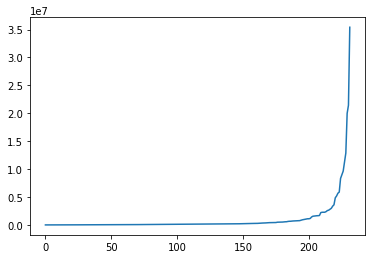

In [599]:
plt.plot(sorted(fake_parameters))
plt.show()

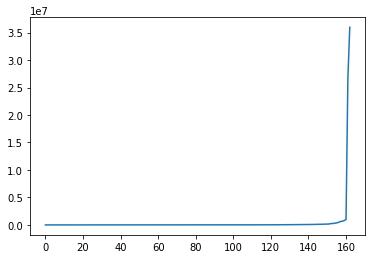

In [600]:
plt.plot(sorted(real_parameters))
plt.show()

In [634]:
np.mean(real_parameters)

429783.35276073619

In [635]:
np.mean(fake_parameters)

987504.33405172417

In [584]:
np.max(pagerank_real)

468514.27607361961

In [585]:
np.mean(hc_real)

468514.27607361961

In [592]:
def find_parameters(d):
    para = []
    for i in d.values():
        para.append((int(i[0])+int(i[1]))/2)
    return para

In [593]:
real_parameters = find_parameters(real_ranks)
fake_parameters = find_parameters(fake_ranks)

In [603]:
[search_site('themacweekly')]

[['153863', '13696008', '1342573', '4.04343108641697e-08', 'com.themacweekly']]

In [606]:
clf.predict([[search_site('themacweekly')[2], search_site('themacweekly')[0]]])

array([1])